# What we will do?
1. import all layers
2. crop the layers to Daegu area
3. extract the layear data from occurrence points
4. use PCA for extracted layer environment (other environment can be added but we just use landsat layers)
5. examine logistic (glm in r) and linear regression(ln in r)
6. generate ranges of PCA component grids and plot the probability components for both logistic and linear regression


# Because of  large gis  datasets may have kernel shortdown error due to  memory issues

In [1]:
import os

# Change the working directory
os.chdir('C:/Users/IT/Downloads/2023')

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\IT\Downloads\2023


In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LinearRegression

In [3]:
# Paths to Landsat bands
band_paths = {
    'B2': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B2.TIF',
    'B3': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B3.TIF',
    'B4': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B4.TIF',
    'B5': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B5.TIF',
    'B10': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B10.TIF',
    'B11': '2013-2023/2023/LC09_L1TP_114035_20230805_20230805_02_T1_B11.TIF'
}

# Read the Daegu boundary shapefile
shapefile_path = 'Daegu/Daegu.shp'
daegu_boundary = gpd.read_file(shapefile_path).to_crs(crs="EPSG:32652")  # Adjust CRS to match the raster CRS
Crop_file=[]
# Iterate over each band
for band_name, band_path in band_paths.items():
    with rasterio.open(band_path) as src:
        out_image, out_transform = mask(src, daegu_boundary.geometry.apply(mapping), crop=True)
        out_meta = src.meta.copy()
        
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": src.crs
        })
        
        # Construct output filename for the cropped band
        output_filename = f"{band_name}_cropped.tif"
        Crop_file.append(output_filename)
        
        # Write the cropped raster to a new file
        with rasterio.open(output_filename, "w", **out_meta) as dest:
            dest.write(out_image)
            
        print(f"Band {band_name} cropped and saved to {output_filename}")


Band B2 cropped and saved to B2_cropped.tif
Band B3 cropped and saved to B3_cropped.tif
Band B4 cropped and saved to B4_cropped.tif
Band B5 cropped and saved to B5_cropped.tif
Band B10 cropped and saved to B10_cropped.tif
Band B11 cropped and saved to B11_cropped.tif


In [4]:
Crop_file

['B2_cropped.tif',
 'B3_cropped.tif',
 'B4_cropped.tif',
 'B5_cropped.tif',
 'B10_cropped.tif',
 'B11_cropped.tif']

<Axes: >

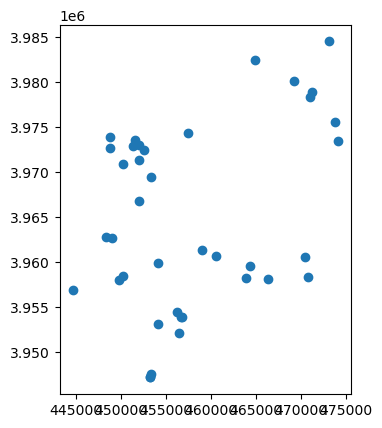

In [5]:
# Path to the shapefile containing examined points
shapefile_path = 'Daegu_point_korea_127/Daegu_point_korea_127.dbf'

# Read the shapefile using GeoPandas
gdf_points = gpd.read_file(shapefile_path)

# Reproject points to match the raster CRS if necessary
gdf_points = gdf_points.to_crs('EPSG:32652')
gdf_points.plot()

In [6]:
# bands = [B2, B3, B4, B5, B10, B11]

In [7]:
raster_paths=Crop_file

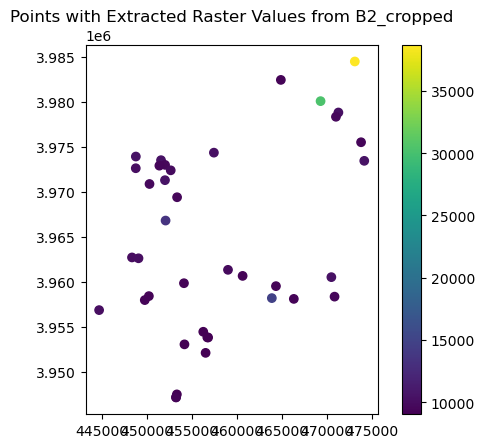

In [8]:
# Open the raster files and read them into arrays
# Function to extract raster values at points
def extract_raster_values(raster_path, gdf):
    with rasterio.open(raster_path) as src:
        # Reproject points to match the raster CRS if necessary
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)
        
        # Extract the coordinates of the points
        coordinates = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
        
        # Extract raster values at point locations
        raster_values = []
        for coord in coordinates:
            row, col = src.index(coord[0], coord[1])
            raster_value = src.read(1)[row, col]
            raster_values.append(raster_value)
    
    return raster_values

# Extract values from each raster and add them to the GeoDataFrame
for raster_path in raster_paths:
    raster_name = raster_path.split('.')[0]  # Extract the raster name without file extension
    gdf_points[raster_name] = extract_raster_values(raster_path, gdf_points)

# Plot the points with raster values for one of the rasters as an example
gdf_points.plot(column='B2_cropped', legend=True)   # similarly we can plot other bands too
plt.title('Points with Extracted Raster Values from B2_cropped')
plt.show()

# # Print the first few rows of the GeoDataFrame with raster values
# print(gdf_points.head())

In [9]:
# gdf_points['B2_cropped', 'B3_cropped', 'B4_cropped', 'B5_cropped', 'B10_cropped', 'B11_cropped']

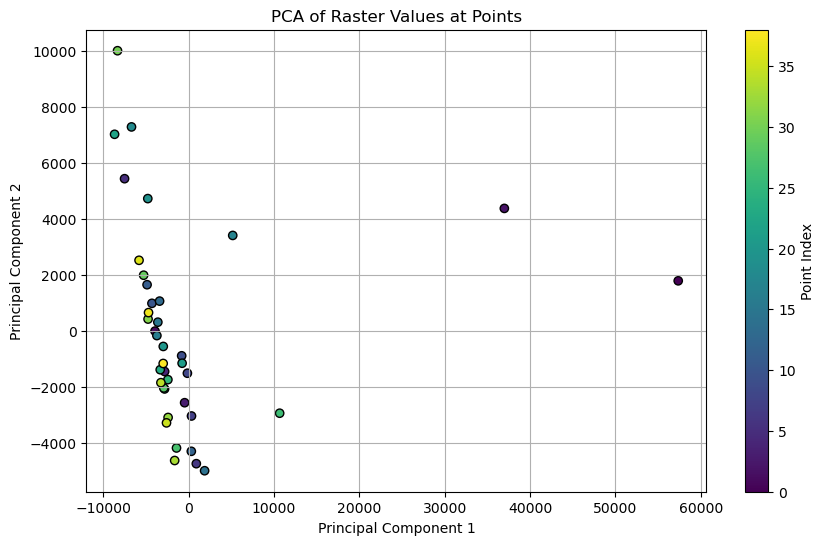

In [10]:
# Step 3: Perform PCA on the environmental variables
pca = PCA(n_components=2)
principal_components = pca.fit_transform(gdf_points[['B2_cropped', 'B3_cropped', 'B4_cropped', 
                                                     'B5_cropped', 'B10_cropped', 'B11_cropped']])

# Add the principal components to the GeoDataFrame
gdf_points['PC1'] = principal_components[:, 0]
gdf_points['PC2'] = principal_components[:, 1]
# gdf_points['PC3'] = principal_components[:, 2]
# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(gdf_points['PC1'], gdf_points['PC2'], c=gdf_points.index, cmap='viridis', edgecolor='k')
plt.colorbar(label='Point Index')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Raster Values at Points')
plt.grid(True)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Principal Component 2')

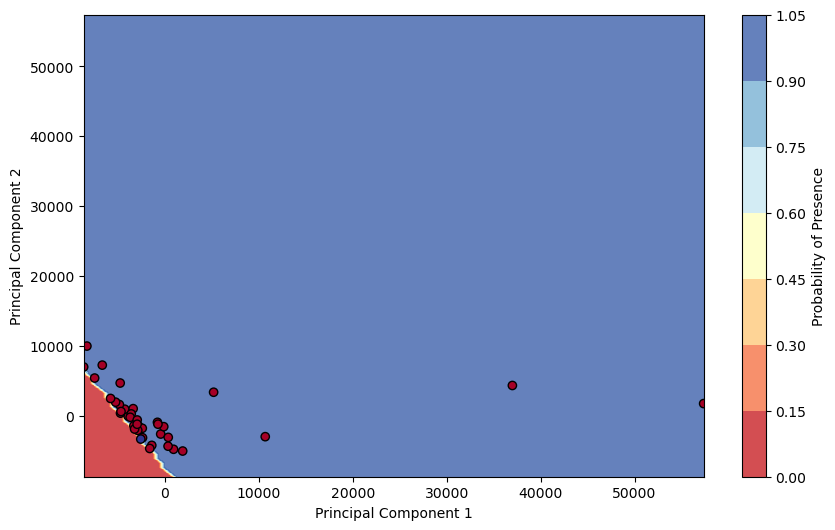

In [11]:
# Step 4: Logistic Regression (glm in r)
X = gdf_points[['PC1', 'PC2']]
y = gdf_points['P__bengale']   ## presence data
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Step 5: Generate a predicted map
# Create a grid of new environmental variable values
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(x_min, x_max, 100))
# Predict presence probabilities over the grid
Z = log_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
# Plot the predicted map
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.colorbar(label='Probability of Presence')
plt.scatter(gdf_points['PC1'], gdf_points['PC2'], c=gdf_points['P__bengale'], edgecolors='k', cmap=plt.cm.RdYlBu_r)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


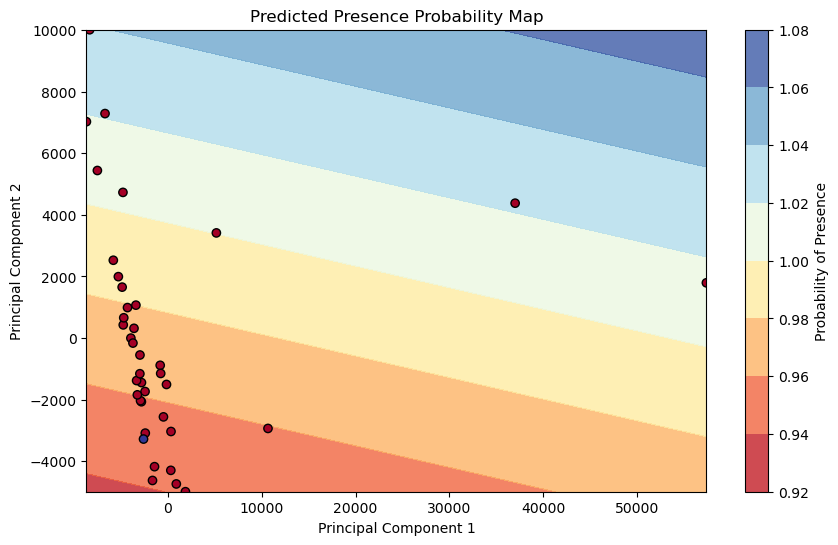

In [12]:
# Assuming gdf_points is a DataFrame with the required columns
X = gdf_points[['PC1', 'PC2']]
y = gdf_points['P__bengale']
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Step 5: Generate a predicted map
# Create a grid of new environmental variable values
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict presence probabilities over the grid
Z = lin_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the predicted map
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.colorbar(label='Probability of Presence')
plt.scatter(gdf_points['PC1'], gdf_points['PC2'], c=gdf_points['P__bengale'], edgecolors='k', cmap=plt.cm.RdYlBu_r)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Predicted Presence Probability Map')
plt.show()

In [13]:
# lin_reg.predict(gdf_points['PC1'].ravel(),gdf_points['PC2'].ravel())
prob=lin_reg.predict(np.c_[gdf_points['PC1'].ravel(), gdf_points['PC2'].ravel()])
gdf_points['prob']=prob

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


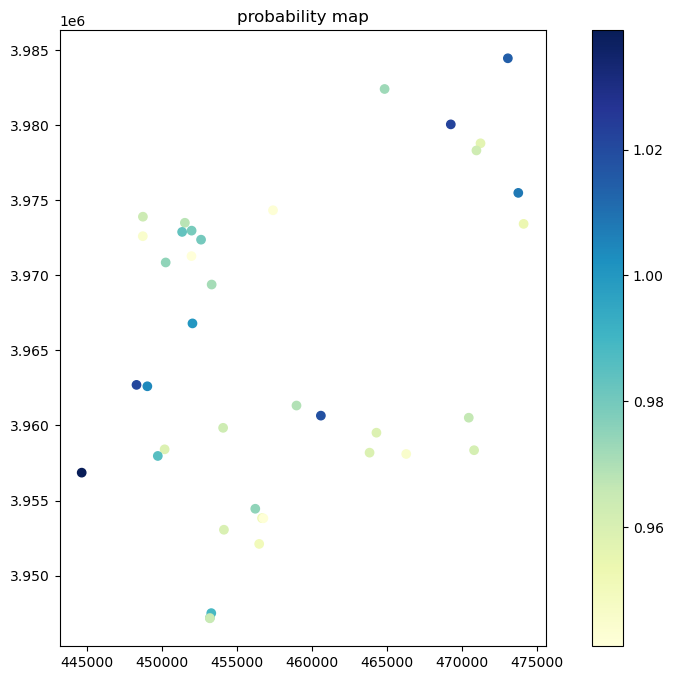

In [14]:
# Plotting with a color map

gdf_points.plot(column='prob', cmap='YlGnBu', legend=True, figsize=(12, 8))

plt.title('probability map')
plt.show()